# Longituditnal data analysis - Regression

In the first two vignettes we discussed the problem of fitting trajectories to observations of a univariate process in multiple patients. In many practical scenarios we also have additional information about the subject, that we might want to use for prediction.

To better understand this scenario, let's use again the bone density dataset from the study of Bachrach et al. (1999).

## Preparing the bones dataset for the analysis

We load the data from the [*Elements of statistical learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) book. This time we still group observations by the subject (connected dots), but we color the points and lines by gender to visualy investigate the effect of gender on progression.

Loading required package: MASS

Loading required package: mvtnorm

Loading required package: fda

Loading required package: splines

Loading required package: Matrix

Loading required package: fds

Loading required package: rainbow

Loading required package: pcaPP

Loading required package: RCurl


Attaching package: ‘fda’


The following object is masked from ‘package:graphics’:

    matplot


Loading required package: fpca

Loading required package: sm

Package 'sm', version 2.2-5.6: type help(sm) for summary information


Attaching package: ‘sm’


The following object is masked from ‘package:MASS’:

    muscle


Loading required package: ggplot2

Loading required package: clusterGeneration

Loading required package: ElemStatLearn

Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:RCurl’:

    complete


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘dplyr’


The follow

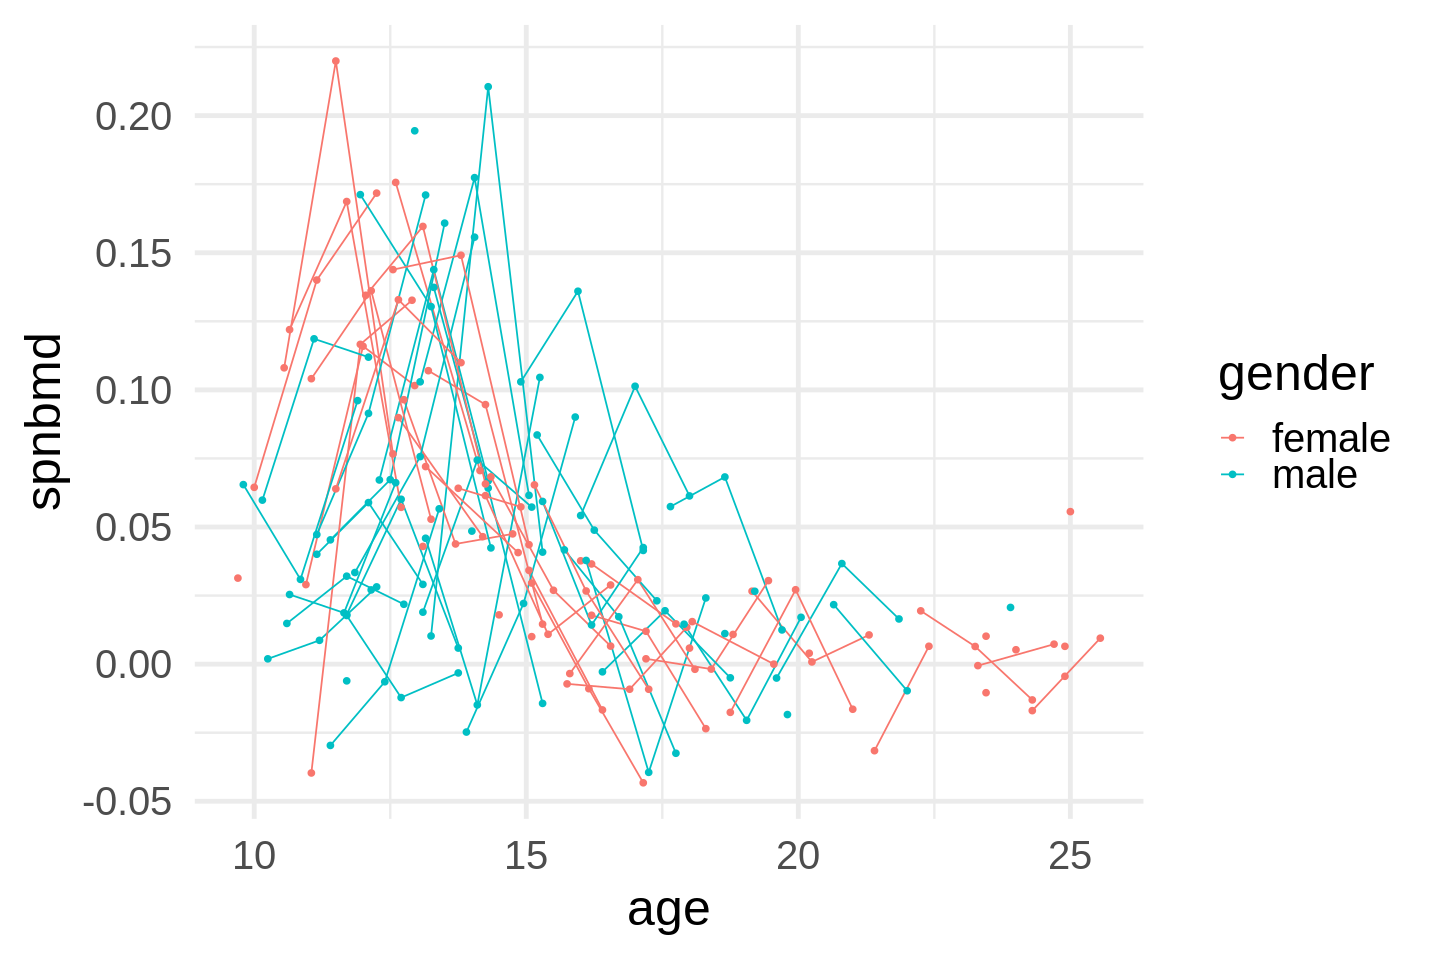

In [1]:
library("fcomplete")
library("dplyr")

options(repr.plot.width=12, repr.plot.height=8)
theme_set(theme_minimal(base_size = 30)) # for presentation clarity

ggplot(aes(x = age, y = spnbmd, group = factor(idnum), color=gender), data = bone[1:200,]) +
    geom_line() + geom_point()

We can hypothesize that bone density is higher in female around the age of 11 and in male around the age of 14. We had similar findings in the [fcomplete vignette](fcomplete.html) where we were analyzing the principal components scores. In this section, we will use regression to account for these trends. To this end, we will simply add gender as a covariate.

In the context described in the introduction, we have one covariate constant in time (gender) so $C = 1$. For each subject $i$, we have $x_{i,1}$ (indicator of the gender) and $n_i$ observations of bone marrow density in time $y_{i,1},...,y_{i,n_i}$. Our goal is to estimate the progression curve for each subject, given this information.

## Fitting the model

To fit the model we will use the Soft-Longitudinal-Regression algorithm from Kidziński and Hastie (2021). We start by fitting a model without covariates (as in the introduction vignette).

In [2]:
model = fregression(spnbmd ~ age | idnum, data = bone, d = 6, K = 3, lambda=c(0.01,0.02), fold=2, verbose = 0)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


Next, we create a covariates matrix -- in this case we will simply summarize our data table and get `gender` of each subjects `idnum`. Our package only accepts numeric variables so we express the factor `male`/`female` as a binary variable `is.male` indicating if a given `idnum` is male or female.

In [3]:
covariates = bone %>%
  group_by(idnum) %>%
  summarize(is.male = (gender[1] == "male")*1 )

Finally, we train a regression model by including the `covariates` table and an extra term `is.male` in the model formula. 

In [4]:
model.gender = fregression(spnbmd ~ age + is.male|idnum,
                           data = bone, covariates = covariates, d = 6,
                           K = 3, lambda=seq(0.01,0.02,length.out = 10),
                           K.reg = 3, lambda.reg=seq(0,0.1,length.out = 10),
                           fold=2, verbose = 0)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


Next we look at the model statistics

In [5]:
model
model.gender

fcomplete fitted using the 'fimpute' method with a formula: ~spnbmdage | idnum
  Number of fitted subjects (N):	 261
  Number of evaluation timpoints:	 51
  Maximum dimension (K):		 3
  Observed to N*K ratio:		 0.6194125
  Estimated r-squared:			 0.8170842

fcomplete fitted using the 'fimpute' method with a formula: ~spnbmdage + is.male | idnum
  Number of fitted subjects (N):	 261
  Number of evaluation timpoints:	 51
  Maximum dimension (K):		 3
  Observed to N*K ratio:		 0.6194125
  Estimated r-squared:			 0.8851682

As we can see, the model that takes gender into account explains more variability in the data. We next visualize three curves from the fitted model.

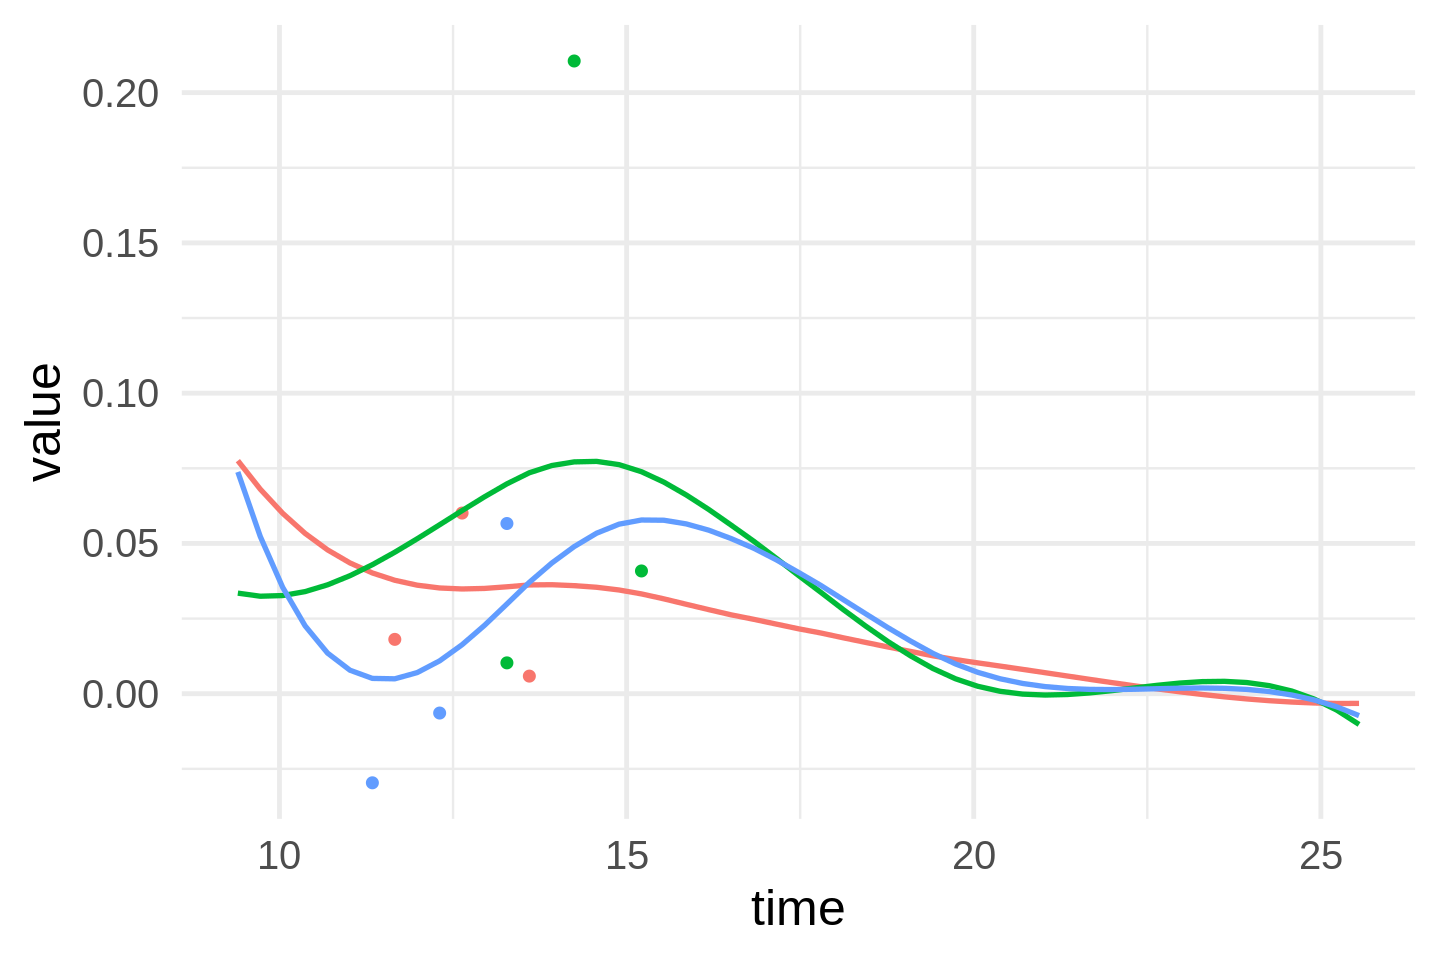

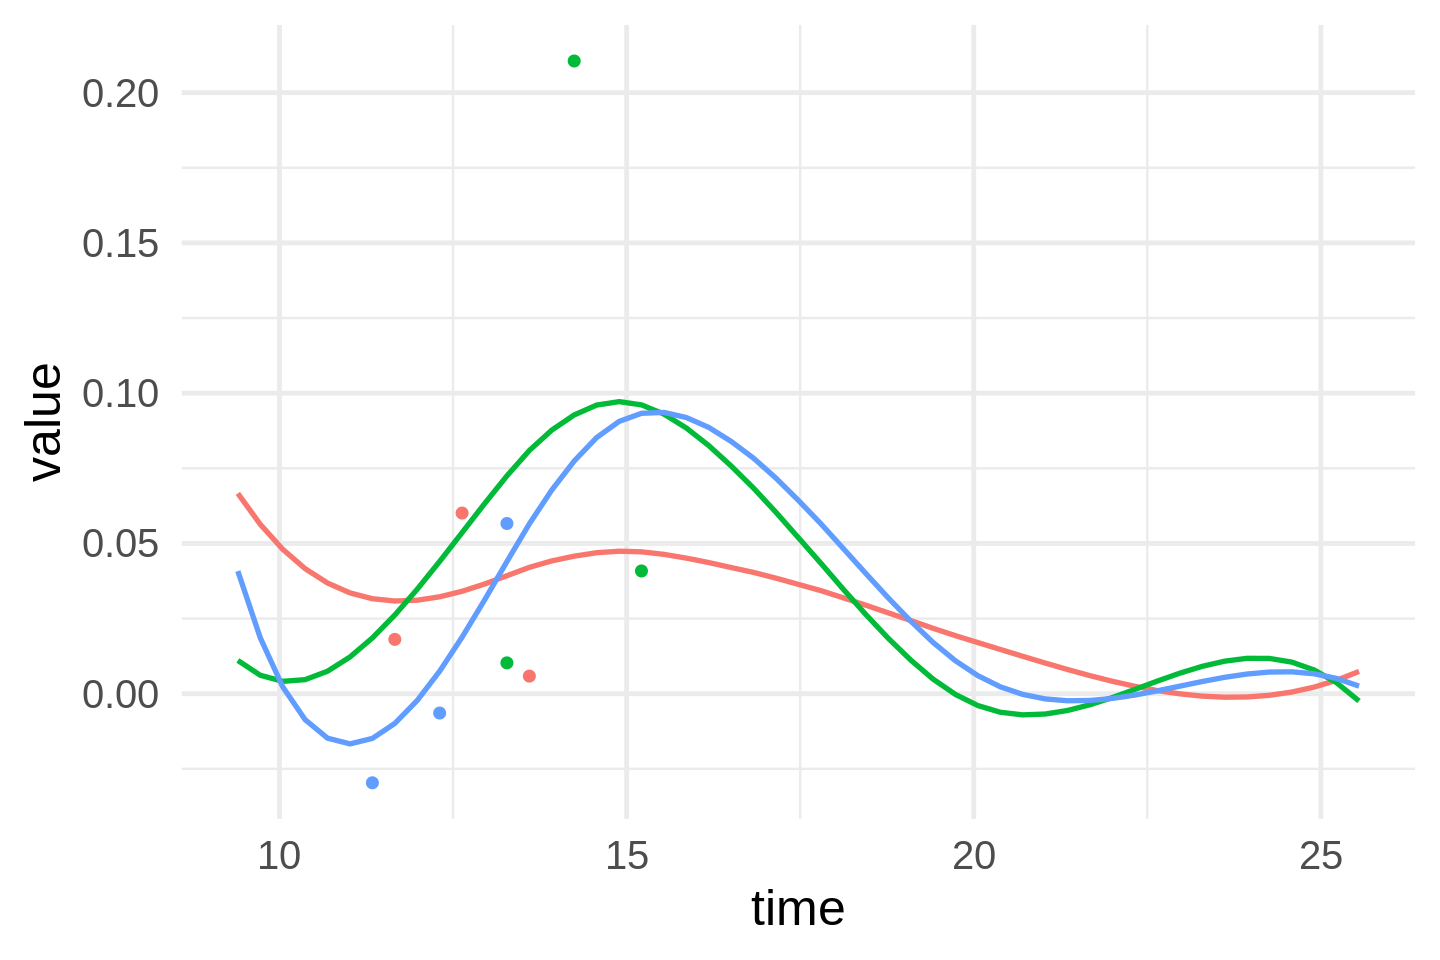

In [6]:
plot(model,rows=covariates$idnum[1:3])
plot(model.gender,rows=covariates$idnum[1:3])

## Model coefficients

**Here we present a simplified representation of the solution. For a formal description of the model please refer to Kidziński, Hastie (2021).**

Suppose we have $N$ subjects, then for each subject $1 \leq i \leq N$, we observe covariates constant over time $x_{i,j}$ for $1 \leq j \leq C$ and some observations of a dependent variable over time $y_{i,t_1},...,y_{i,t_{n_i}}$, where $n_i$ is the number of measurements and $t_1 < ... < t_{n_i}$ are some timepoints.

As in the functional impute described in previous vignettes each subject is represented by a latent vector $w_i \in \mathbb{R}^K$ which corresponds to coefficients in some fitted basis. The basis is composed of $K$ components $v_j \in \mathbb{R}^T$, for $j \in \{1,2,3,...,K\}$, where $T$ is the size of the evaluation grid and they have their own weights $d_1,...,d_k$.

Moreover, for each subject we have covariates $x_j$ (constant over time for each subject) and they are assumed to influence the trajectories. Again, these covariates will have corresponing progression patterns. We fit another basis $\{u_j\}_j$. In the end, each subject is represented by their estimated trajectory $S_j \in \mathbb{R}^T$ given by:

$$
  S_j = \mu + \sum_{j=1}^K w_{i,j} d_j v_j + \sum_{j=1}^C x_{i,j} u_j.
$$

We can extract all model parameters using the `coef` function:

In [7]:
mdl.coefs = coef(model.gender)
mdl.coefs

$components
            [,1]        [,2]       [,3]       [,4]       [,5]       [,6]
[1,]  0.12046435 -0.01514808 -0.1228271 -0.2048511 -0.2634986 -0.3010480
[2,]  0.31331611  0.26052237  0.2080784  0.1564070  0.1059309  0.0570726
[3,] -0.05703571 -0.08525663 -0.1063905 -0.1211797 -0.1303666 -0.1346934
            [,7]        [,8]        [,9]      [,10]      [,11]      [,12]
[1,] -0.31977771 -0.32196625 -0.30989204 -0.2858335 -0.2520692 -0.2108774
[2,]  0.01025497 -0.03409932 -0.07556758 -0.1137271 -0.1481552 -0.1784291
[3,] -0.13490255 -0.13173631 -0.12593703 -0.1182470 -0.1094087 -0.1001643
           [,13]       [,14]       [,15]       [,16]       [,17]       [,18]
[1,] -0.16453663 -0.11532537 -0.06552203 -0.01740507  0.02674706  0.06467354
[2,] -0.20412622 -0.22482377 -0.24009907 -0.24952942 -0.25269211 -0.24917248
[3,] -0.09125615 -0.08342664 -0.07741808 -0.07397280 -0.07383312 -0.07773225
           [,19]       [,20]     [,21]      [,22]      [,23]      [,24]
[1,]  0.09517004  0.11866982  0.135747  0.1469758  0.1529303  0.1541846
[2,] -0.23903832 -0.22310521 -0.202253 -0.1773617 -0.1493111 -0.1189812
[3,] -0.08585583 -0.09754078 -0.112051 -0.1286504 -0.1466029 -0.1651723
           [,25]       [,26]       [,27]        [,28]       [,29]       [,30]
[1,]  0.15131286  0.14488927  0.13548794  0.123683006  0.11004861  0.09515888
[2,] -0.08725175 -0.05500278 -0.02311416  0.007534221  0.03606246  0.06159065
[3,] -0.18362270 -0.20121785 -0.21722171 -0.230898178 -0.24151116 -0.24832456
           [,31]       [,32]       [,33]      [,34]       [,35]       [,36]
[1,]  0.07958797  0.06391001  0.04869914  0.0345295  0.02194383  0.01111981
[2,]  0.08323890  0.10012730  0.11137596  0.1161050  0.11354380  0.10419310
[3,] -0.25060228 -0.24760823 -0.23860632 -0.2228605 -0.19975309 -0.17004502
            [,37]        [,38]       [,39]       [,40]        [,41]       [,42]
[1,]  0.001999621 -0.005478488 -0.01137627 -0.01575547 -0.018677849 -0.02020515
[2,]  0.089373720  0.070420135  0.04866684  0.02544833  0.002099094 -0.02004638
[3,] -0.135386261 -0.097441643 -0.05787601 -0.01835418  0.019458992  0.05389868
           [,43]       [,44]       [,45]       [,46]        [,47]        [,48]
[1,] -0.02039913 -0.01932154 -0.01703412 -0.01359863 -0.009076824 -0.003530447
[2,] -0.03965359 -0.05538805 -0.06591527 -0.06990075 -0.066010013 -0.052908557
[3,]  0.08330004  0.10599825  0.12032846  0.12462585  0.117225568  0.096462786
            [,49]       [,50]       [,51]
[1,]  0.002978747 0.010389009  0.01863859
[2,] -0.029261892 0.006264474  0.05500503
[3,]  0.060672668 0.008190377 -0.06264892

$scores
                [,1]          [,2]          [,3]
  [1,]  3.803053e-02  1.040119e-01  4.641384e-02
  [2,]  6.458263e-02 -7.657111e-02  4.269895e-02
  [3,]  1.459398e-01 -2.539673e-02  6.204587e-02
  [4,] -1.177407e-01  8.703516e-02 -4.506443e-02
  [5,] -5.959636e-05  1.856417e-02 -1.842430e-03
  [6,]  1.341088e-03  7.839880e-05 -2.836854e-03
  [7,] -5.340486e-02 -4.945950e-02 -8.975868e-03
  [8,] -1.966419e-01 -1.665689e-01 -1.060638e-01
  [9,]  2.905531e-03  7.582797e-03 -1.555333e-03
 [10,] -2.746214e-02 -3.877076e-02  1.025679e-01
 [11,]  6.457300e-02  4.276617e-02  3.829485e-02
 [12,]  3.531186e-02 -3.622559e-02 -4.022721e-02
 [13,] -1.529661e-01 -3.607285e-02 -6.047933e-02
 [14,]  2.360387e-02 -3.524024e-02 -2.211733e-02
 [15,] -6.013998e-03  5.683777e-02  1.885229e-02
 [16,]  1.002776e-01  1.063670e-02  4.652134e-02
 [17,]  2.783543e-04 -5.050074e-02  8.414133e-02
 [18,]  8.726886e-03  5.629518e-03 -2.579615e-02
 [19,] -4.447464e-02  1.688830e-02  4.578837e-02
 [20,] -4.825067e-03  1.087015e-02  1.944190e-03
 [21,] -3.141555e-02  4.695259e-02  1.479239e-02
 [22,]  3.186334e-02 -1.275996e-01  3.292112e-02
 [23,] -2.128770e-01  5.917957e-02  8.930385e-03
 [24,] -5.512168e-02 -5.419642e-02 -1.710513e-02
 [25,] -5.445149e-04 -2.822882e-03  5.626638e-03
 [26,] -1.052698e-03  1.387307e-02 -3.410795e-02
 [27,] -3.513545e-03 -1.843117e-02  3.727854e-02
 [2

Where

| variable | list element | description |
| ---: | :- | :- |
| $\mu$ | `$means` | the intercept curve |
| $w_{i,j}$ | `$scores` | principal component scores | 
| $d_j$ | `$weights` | importance of principal components (weights, 'lambdas') |
| $v_j$ | `$components` | principal components |
| $u_j$ | `$regression` | regression coefficients (when regressing each timepoint on $X$) | 

Note that we have two regression vectors despite having only one regression variable, because our package automatically adds the intercept. To find the actual mean curve per gender, we need to add the intercept

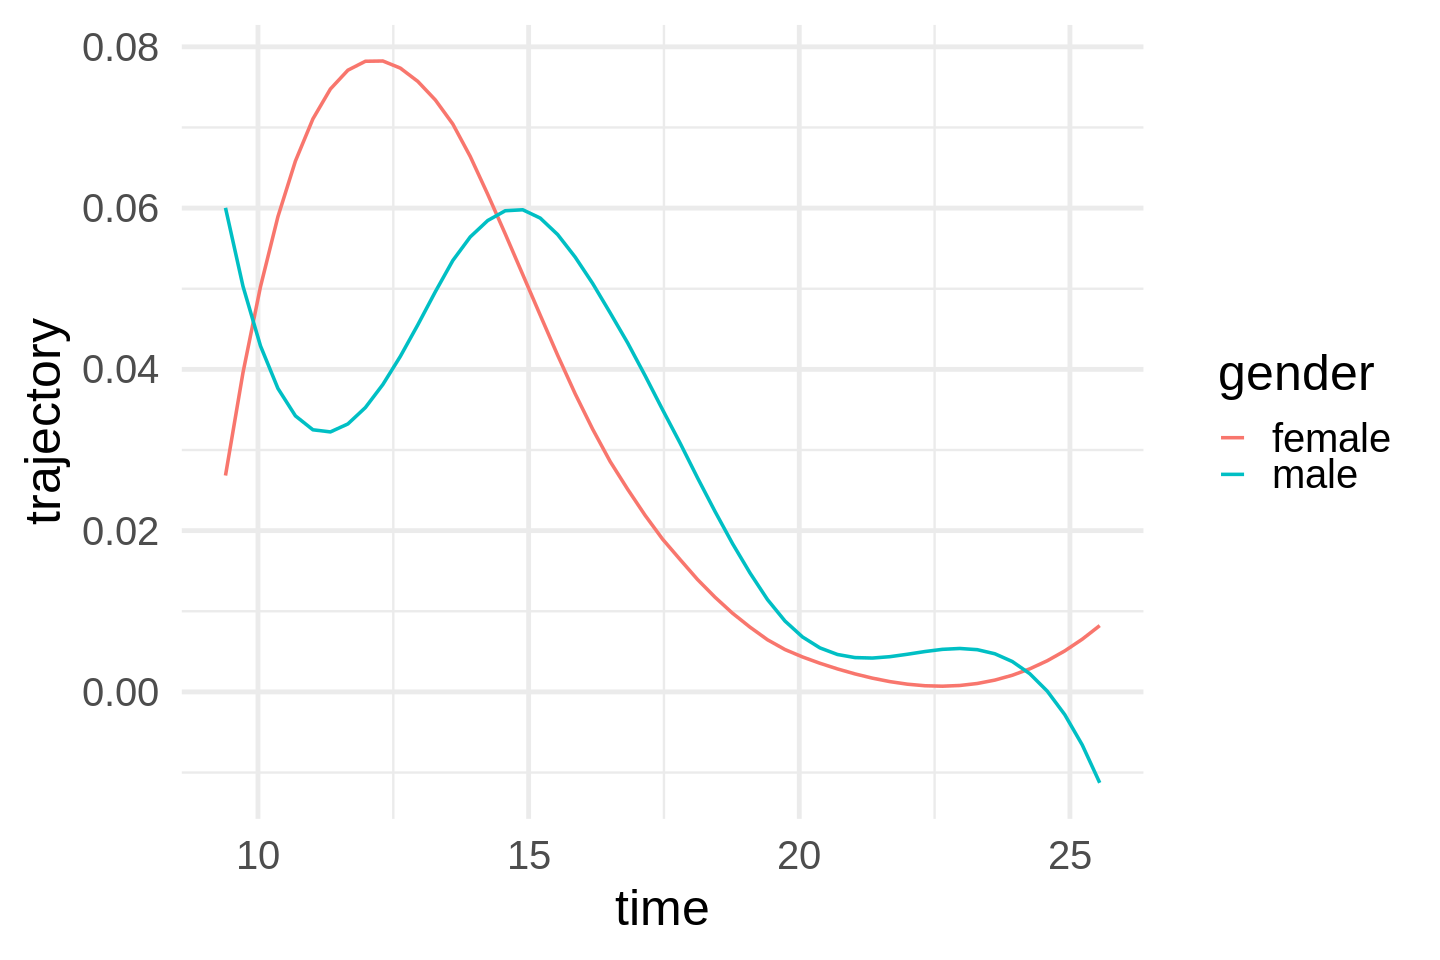

In [8]:
data = data.frame(time = model.gender$time.grid, gender = t(mdl.coefs$regression)+mdl.coefs$means)
colnames(data)[2:3] = c("female","male")
data = data %>% gather(gender, trajectory, female:male)
ggplot(data, aes(x=time,y=trajectory,color=gender)) + geom_line(size=1)